In [2]:
import os
import glob
from PIL import Image

def render_and_save_images(source_folder, output_folder, image_size=1024, pixel_resolution=0.08, clip_distance=100):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Glob all .ply files in the source folder
    file_paths = glob.glob(os.path.join(source_folder, '*.ply'))
    print(file_paths)
    # Loop through all the files and process them
    for i, file_path in enumerate(file_paths):
        images = render_mesh(file_path, 0.40, 0.55, image_size=image_size, pixel_resolution=pixel_resolution, clip_distance=clip_distance)
        for idx, img_array in enumerate(images):
            img = Image.fromarray(img_array)
            # Define the output path for the image
            output_path = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(file_path))[0]}_{idx}.png')
            # Save the image to the output folder
            img.save(output_path)
            print(f'Saved {output_path} {i}/{len(file_paths)}', end="\r", flush=True)

# Example usage
render_and_save_images('meshes/Test', 'output_images_Test', clip_distance=10)

['meshes/Test/Brunatest_UpperJawScan.ply']


/tmp/ipykernel_380/4076364273.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  vertices = torch.tensor(ply.vertices, dtype=torch.float32)


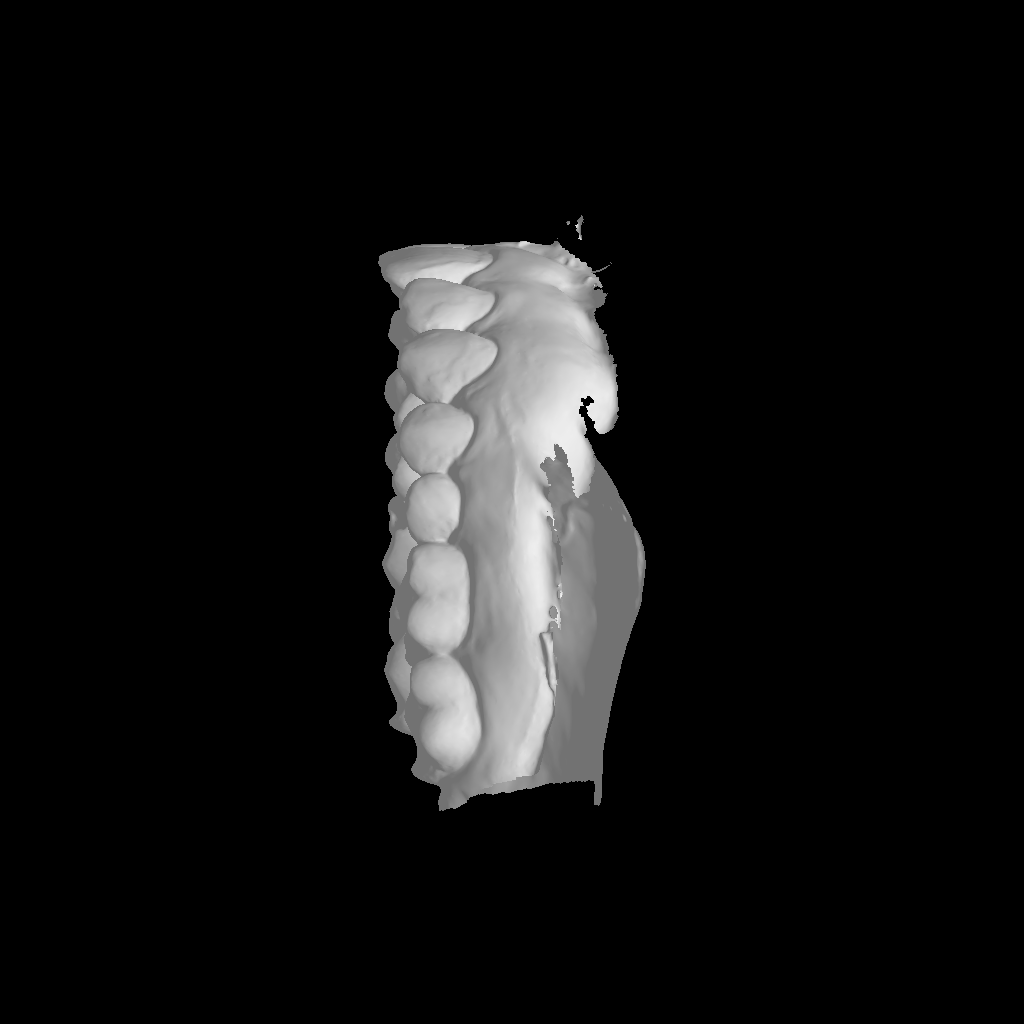

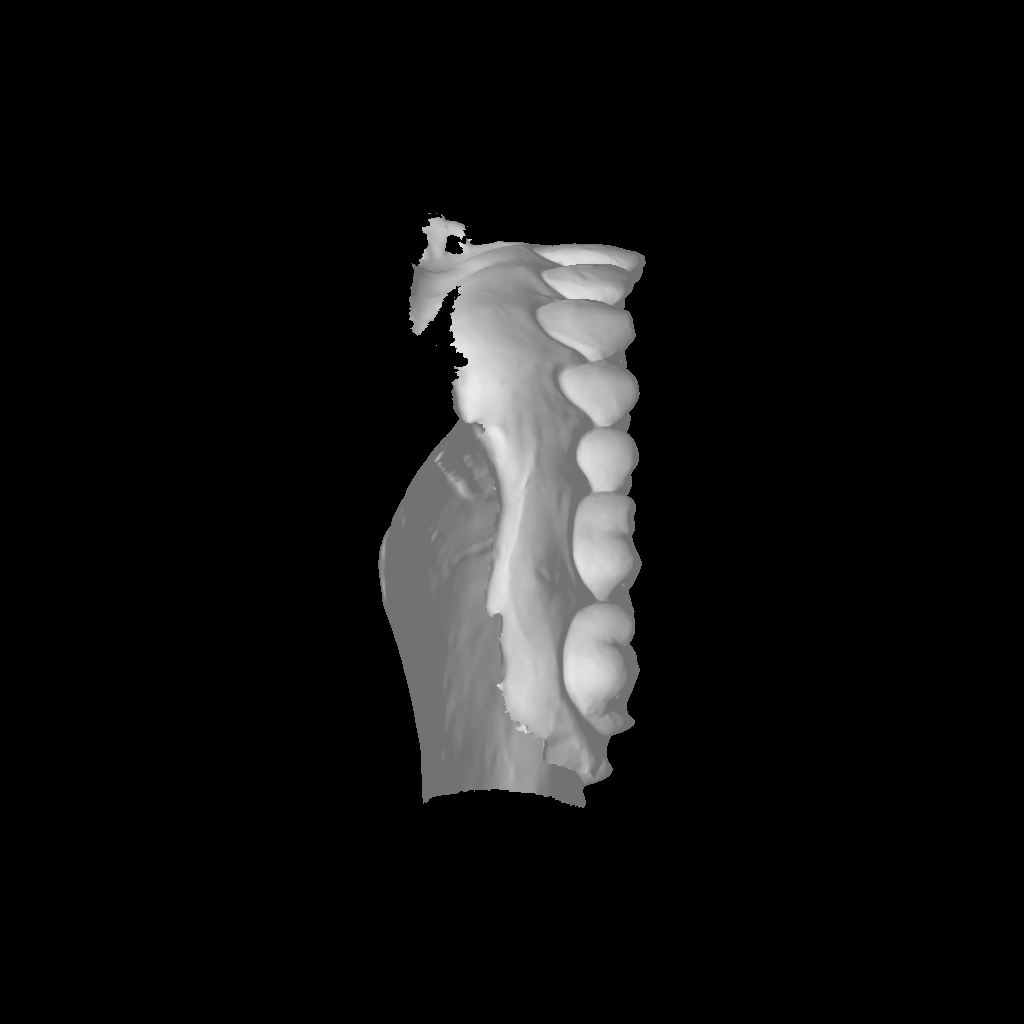

In [9]:
import torch
from pytorch3d.io import load_ply
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform, FoVOrthographicCameras, RasterizationSettings, MeshRenderer,
    MeshRasterizer, SoftPhongShader, DirectionalLights, TexturesVertex, BlendParams
)
import open3d as o3d
from PIL import Image

def render_mesh(mesh_filename, amb_col, diff_col, image_size=512, pixel_resolution = 0.1, clip_distance=100):
    # Load the .ply file
    ply = o3d.io.read_triangle_mesh(mesh_filename)
    
    # Convert Open3D format to PyTorch tensors
    vertices = torch.tensor(ply.vertices, dtype=torch.float32)
    faces = torch.tensor(ply.triangles, dtype=torch.int64)
    
    # Create a PyTorch3D mesh
    constant_color = torch.tensor([[1.0, 1.0, 1.0]])  # White color
    colors = constant_color.repeat(vertices.shape[0], 1).unsqueeze(0)  # [1, num_vertices, 3]
    textures = TexturesVertex(verts_features=colors)
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
    
    # Setup the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mesh = mesh.to(device)


    # Define the blend parameters with a black background color
    blend_params = BlendParams(background_color=(0, 0, 0))  # RGB values for black

    # Calculate the bounding box and size of the model
    min_vals, _ = vertices.min(0)
    max_vals, _ = vertices.max(0)
    center = (max_vals + min_vals) / 2
    max_extent = (max_vals - min_vals).max()
    
    # Setup the renderer and shaders
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
        cull_backfaces=True, clip_barycentric_coords=True
    )
    directions = torch.tensor([[1, 0, 0], [-1, 0, 0]], dtype=torch.float32)
    eye_positions = center + directions * max_extent * 1.5
    at_positions = center.unsqueeze(0).expand_as(eye_positions)
    up_vectors = torch.tensor([[0, 0, 1], [0, 0, 1]], dtype=torch.float32)
    
    lights = DirectionalLights(
        device=device,
        direction=[[1, 1, 0], [-1, 1, 0]],
        ambient_color=((amb_col, amb_col, amb_col),),
        diffuse_color=((diff_col, diff_col, diff_col),),
        specular_color=((0.0, 0.0, 0.0),)
    )
    
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, lights=lights, blend_params=blend_params )
    )
    
    # Generate view transformations
    R, T = look_at_view_transform(eye=eye_positions, at=at_positions, up=up_vectors)
    
    # Create batched cameras
    cameras = FoVOrthographicCameras(device=device, R=R, T=T,
                                     znear=0.3 * max_extent, zfar=clip_distance + 1.5* max_extent,
                                     max_x=image_size*pixel_resolution/2, max_y=image_size*pixel_resolution/2,
                                     min_x=-image_size*pixel_resolution/2, min_y=-image_size*pixel_resolution/2)

    # Assuming 'mesh' is the original mesh
    # Replicate the mesh data for each camera view
    meshes = mesh.extend(directions.size(0))
    
    # Render all views in one call
    images = renderer(meshes, cameras=cameras)

    images = torch.clamp(images, 0, 1)
    
    # Convert images to numpy arrays for display
    images_np = [(img[..., :3].cpu().numpy() * 255).astype("uint8") for img in images]
    return images_np

# Example usage
images = render_mesh("meshes/Test/Brunatest_UpperJawScan.ply", 0.45, 0.5, image_size=1024, pixel_resolution = 0.08)
for img_array in images:
    img = Image.fromarray(img_array)
    img.show()

In [10]:
import os
from PIL import Image

# Path to the image folder
image_folder = "output_images_Test"
output_folder = "output_images_Test_rotated"
os.makedirs(output_folder, exist_ok=True)

# Get all PNG files
image_files = [f for f in os.listdir(image_folder) if f.endswith(".png")]

for filename in image_files:
    # Extract the last digit before the .png
    number_str = filename.split("_")[-1].split(".")[0]

    if not number_str.isdigit():
        print(f"Skipping {filename} (no numeric ending)")
        continue

    number = int(number_str)
    img_path = os.path.join(image_folder, filename)
    img = Image.open(img_path)

    if number % 2 == 0:
        # Even number: Rotate 90 degrees clockwise
        img = img.rotate(-90, expand=True)
        print(f"{filename}: Rotated 90° clockwise")
    else:
        # Odd number: Flip vertically (X-axis), then rotate 90° clockwise
        img = img.transpose(Image.FLIP_TOP_BOTTOM).rotate(-90, expand=True)
        print(f"{filename}: Flipped on X-axis and rotated 90° clockwise")
    # Save back to the same location (overwrite)
    output_path = os.path.join(output_folder, filename)
    img.save(output_path)

Brunatest_UpperJawScan_1.png: Flipped on X-axis and rotated 90° clockwise
Brunatest_UpperJawScan_0.png: Rotated 90° clockwise
